In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, functions as F, Window
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import DataFrame
from functools import reduce
from statsmodels.graphics.tsaplots import plot_acf



In [15]:
df = pd.read_csv("/Users/lucasking/Library/CloudStorage/OneDrive-Personal/桌面/BU/2025 Spring/MF 810 Advanced programming/Final project/datasets/stock_data_5yr.csv")
df_clean = df.copy()



In [16]:
print(df.shape)
print(df_clean.shape)

(1201726, 79)
(1201726, 79)


In [17]:

base_cols = [
    "Date", "Open", "High", "Low", "Close",
    "Volume", "Dividends", "Stock Splits", "Ticker"
]

# indicators
indicator_cols = [col for col in df.columns if col not in base_cols]

print("Indicators：", indicator_cols)

# drop nan
df_clean = df.dropna(subset=indicator_cols, how="any")

print(f"Old data has {len(df)} rows，After cleaned {len(df_clean)} rows")


print(df_clean[indicator_cols].isna().mean().sort_values(ascending=False))

Indicators： ['Return1', 'Gap', 'HL_Range', 'OC_Return', 'SMA5', 'EMA5', 'SMA10', 'EMA10', 'SMA20', 'EMA20', 'SMA50', 'EMA50', 'SMA100', 'EMA100', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI14', 'ROC5', 'ROC10', 'ROC20', 'StochK', 'StochD', 'WilliamsR14', 'BB_HBand', 'BB_LBand', 'BB_Width', 'KC_HBand', 'KC_LBand', 'DC_HBand', 'DC_LBand', 'ATR14', 'ATR28', 'CCI20', 'ADX14', 'MassIndex', 'UltimateOsc', 'CMO14', 'OBV', 'AccDistIdx', 'ChaikinMF20', 'ForceIdx1', 'EaseOfMov14', 'VWAP14', 'Ichimoku_Conv', 'Ichimoku_Base', 'Vortex_pos', 'Vortex_neg', 'RollMaxH5', 'RollMinL5', 'RollMaxH10', 'RollMinL10', 'RollMaxH20', 'RollMinL20', 'RollMaxH50', 'RollMinL50', 'Autocorr1', 'Skew10', 'Kurt10', 'Sharpe10', 'Drawdown20', 'ZScore10', 'SMA5_20_D', 'Momentum5', 'Momentum10', 'Vol_Ret5', 'Vol_Ret10', 'Vol_Ret20', 'Vol_MA5', 'Vol_MA10']
Old data has 1201726 rows，After cleaned 1102008 rows
Return1          0.0
Ichimoku_Conv    0.0
RollMaxH10       0.0
RollMinL5        0.0
RollMaxH5        0.0
               

In [18]:
df_clean.shape

(1102008, 79)

### Delete 8.29% data

In [19]:
df_clean.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Return1,...,Drawdown20,ZScore10,SMA5_20_D,Momentum5,Momentum10,Vol_Ret5,Vol_Ret10,Vol_Ret20,Vol_MA5,Vol_MA10
89756,2020-09-16 00:00:00-04:00,98.074359,98.365003,95.022553,96.805191,1365000,0.0,0.0,A,-0.004483,...,-0.080062,0.423359,0.382684,0.020321,-0.011867,0.005948,0.021147,0.015243,1385660.0,1431750.0
89757,2020-09-16 00:00:00-04:00,13.423161,13.577450,13.215835,13.403874,5583300,0.0,0.0,AA,0.008708,...,-0.099935,-0.755348,-0.634997,-0.014185,-0.078860,0.017018,0.016956,0.023000,4408840.0,4358180.0
89758,2020-09-16 00:00:00-04:00,13.210000,13.960000,12.980000,13.800000,75200100,0.0,0.0,AAL,0.050228,...,-0.118841,1.707258,0.093500,0.057471,0.053435,0.025242,0.024189,0.033969,50050660.0,61224690.0
89759,2020-09-16 00:00:00-04:00,37.456000,38.047958,37.345417,37.625134,305700,0.0,0.0,AAON,0.007666,...,-0.066756,1.406420,-0.334034,0.039540,0.012251,0.003687,0.010729,0.008754,325530.0,280395.0
89760,2020-09-16 00:00:00-04:00,112.360634,113.111457,109.250067,109.337822,154679000,0.0,0.0,AAPL,-0.029513,...,-0.165300,-0.847044,-7.138451,-0.044238,-0.164331,0.025638,0.038061,0.034320,168521160.0,204123870.0


In [20]:
print(df.columns.tolist())

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'Return1', 'Gap', 'HL_Range', 'OC_Return', 'SMA5', 'EMA5', 'SMA10', 'EMA10', 'SMA20', 'EMA20', 'SMA50', 'EMA50', 'SMA100', 'EMA100', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI14', 'ROC5', 'ROC10', 'ROC20', 'StochK', 'StochD', 'WilliamsR14', 'BB_HBand', 'BB_LBand', 'BB_Width', 'KC_HBand', 'KC_LBand', 'DC_HBand', 'DC_LBand', 'ATR14', 'ATR28', 'CCI20', 'ADX14', 'MassIndex', 'UltimateOsc', 'CMO14', 'OBV', 'AccDistIdx', 'ChaikinMF20', 'ForceIdx1', 'EaseOfMov14', 'VWAP14', 'Ichimoku_Conv', 'Ichimoku_Base', 'Vortex_pos', 'Vortex_neg', 'RollMaxH5', 'RollMinL5', 'RollMaxH10', 'RollMinL10', 'RollMaxH20', 'RollMinL20', 'RollMaxH50', 'RollMinL50', 'Autocorr1', 'Skew10', 'Kurt10', 'Sharpe10', 'Drawdown20', 'ZScore10', 'SMA5_20_D', 'Momentum5', 'Momentum10', 'Vol_Ret5', 'Vol_Ret10', 'Vol_Ret20', 'Vol_MA5', 'Vol_MA10']


In [21]:
df_clean.isna().sum().sum()

0

### get fundamental data from yfinance

In [22]:
import pandas as pd
import yfinance as yf
import time

# 1. 先把所有 ticker 撈出來
tickers = df_clean["Ticker"].dropna().unique().tolist()
print(f"總共要抓 {len(tickers)} 檔股票的基本面資料")

# 2. 定義一個帶重試機制的抓取函式
def fetch_info_with_retry(ticker, max_retries=3):
    for attempt in range(1, max_retries+1):
        try:
            info = yf.Ticker(ticker).info
            # 你要的那些欄位都放進 dict 裡
            return {
                "Ticker":        ticker,
                "marketCap":     info.get("marketCap"),
                "trailingPE":    info.get("trailingPE"),
                "forwardPE":     info.get("forwardPE"),
                "priceToBook":   info.get("priceToBook"),
                "dividendYield": info.get("dividendYield"),
                "beta":          info.get("beta"),
            }
        except Exception as e:
            txt = str(e).lower()
            if "rate limited" in txt or "too many requests" in txt:
                wait = attempt * 5
                print(f"[Rate limit] {ticker} 第 {attempt} 次重試，等待 {wait}s …")
                time.sleep(wait)
            else:
                print(f"[Error] {ticker}: {e}")
                break
    print(f"[Fail] {ticker} 抓取失敗")
    return None

# 3. 分批抓、之間加 sleep
results = []
batch_size = 50
for idx, tk in enumerate(tickers, start=1):
    rec = fetch_info_with_retry(tk)
    if rec:
        results.append(rec)
    # 每支股票之間睡一秒，避免短時間連續打爆 API
    time.sleep(1)

    # 每抓完一個 batch，就多睡 60 秒
    if idx % batch_size == 0:
        print(f"已處理 {idx} 支股票，sleep 60s …")
        time.sleep(60)

# 4. 合成 DataFrame
fund_df = pd.DataFrame(results)
print("抓到的基本面資料：")
print(fund_df.head())

# 5. （可選）跟原本的 df_clean 做 merge
merged = pd.merge(df_clean,
                  fund_df,
                  on="Ticker",
                  how="left")
print("合併後範例：")
print( merged.loc[:, ["Date","Ticker","trailingPE","priceToBook","dividendYield"]].head() )

總共要抓 986 檔股票的基本面資料


KeyboardInterrupt: 

In [ ]:
merged.head()

## Analyze the correlations between Next data return and the various indicators

In [ ]:

df_clean = (
    df_clean
    .sort_values(["Ticker", "Date"])
    .reset_index(drop=True)
)

#  group by the tickers
df_clean["Close_next"] = (
    df_clean
    .groupby("Ticker")["Close"]
    .shift(-1)
)

# define 1, 0 for up/ down for tomorrow
df_clean["Target"] = (df_clean["Close_next"] > df_clean["Close"]).astype(int)

# drop the last nan
df_clean = df_clean.dropna(subset=["Target"])

# Define features
exclude = [
    "Date", "Ticker", "Close_next", "Target", "Open", "High", "Low", "Close", "Volume"
]
feature_cols = [c for c in df_clean.columns if c not in exclude]

# By tickers
X_by_ticker = {}
y_by_ticker = {}
for tkr, group in df_clean.groupby("Ticker"):
    X_by_ticker[tkr] = group[feature_cols]
    y_by_ticker[tkr] = group["Target"]

# # AAPL
# X_AAPL = X_by_ticker["AAPL"]
# y_AAPL = y_by_ticker["AAPL"]

# General Test
X = df_clean[feature_cols]
y = df_clean["Target"]



RF Test Accuracy: 0.5065193197293425
RF Top 15 features:
 Gap            0.022345
MassIndex      0.022136
Autocorr1      0.021469
ChaikinMF20    0.021178
UltimateOsc    0.021018
Skew10         0.020628
Kurt10         0.020551
HL_Range       0.020367
Vol_Ret5       0.020119
OC_Return      0.020107
ADX14          0.020042
ZScore10       0.019895
Vortex_pos     0.019874
Vortex_neg     0.019781
ROC20          0.019733
dtype: float64


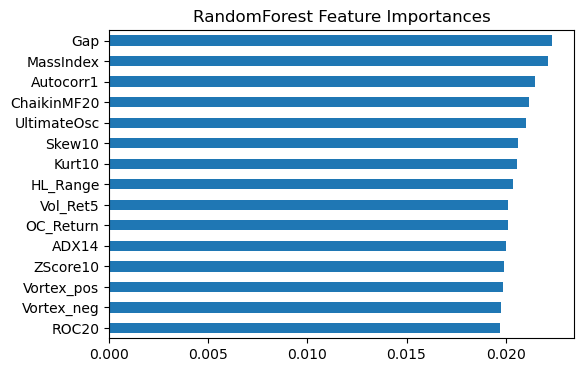

LR Top 15 features:
 Vol_MA5          2.653097e-09
Vol_MA10         1.970963e-09
EaseOfMov14      1.012775e-09
ForceIdx1        1.006765e-10
AccDistIdx       1.609697e-11
OBV              5.765813e-12
RollMaxH50       2.843237e-12
DC_HBand         2.807190e-12
RollMaxH20       2.807190e-12
BB_HBand         2.804302e-12
RollMaxH10       2.738867e-12
KC_HBand         2.723443e-12
RollMaxH5        2.693669e-12
SMA50            2.681300e-12
Ichimoku_Base    2.669754e-12
dtype: float64
RF TimeSeries CV Accuracy: [0.52585386 0.53498451 0.53906254 0.53802806 0.53807162] mean= 0.5352001176041423


In [ ]:
# from start to 20230101 for test, others for test

split_date = "2023-01-01"
train_mask = df_clean["Date"] < split_date
X_train, y_train = df_clean.loc[train_mask, feature_cols], df_clean.loc[train_mask, "Target"]
X_test,  y_test  = df_clean.loc[~train_mask, feature_cols], df_clean.loc[~train_mask, "Target"]

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

#Test
y_pred = rf.predict(X_test)
print("RF Test Accuracy:", accuracy_score(y_test, y_pred))

# importance of features
imp_rf = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("RF Top 15 features:\n", imp_rf.head(15))


plt.figure(figsize=(6,4))
imp_rf.head(15).plot.barh()
plt.gca().invert_yaxis()
plt.title("RandomForest Feature Importances")
plt.show()

# L1 regression
lr = LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=5000, n_jobs=-1)
lr.fit(X_train, y_train)
coef_abs = pd.Series(np.abs(lr.coef_[0]), index=feature_cols).sort_values(ascending=False)
print("LR Top 15 features:\n", coef_abs.head(15))

# —Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(rf, df_clean[feature_cols], df_clean["Target"],
                            cv=tscv, scoring="accuracy", n_jobs=-1)
print("RF TimeSeries CV Accuracy:", cv_scores, "mean=", cv_scores.mean())

## Using parquet data to do research

In [2]:
import pandas as pd
import duckdb
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MF810_Final_Project") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


path = "/Users/lucasking/Desktop/datasets/merged_cleaned.parquet"

# Covnert Parquet into DF
df = spark.read.parquet(path)
df = df.filter(F.col("ticker") != "merged_raw")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/29 21:27:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# test by AAPL
con = duckdb.connect()
df_aapl = (
    con
    .execute(f"""
        SELECT *
        FROM read_parquet('{path}')
        WHERE ticker = 'AAPL'
        LIMIT 5;
    """)
    .df()
)
print("=== DuckDB Query for AAPL ===")
print(df_aapl.head())

=== DuckDB Query for AAPL ===
   volume      vwap    open   close    high     low      timestamp  \
0  3056.0  164.0985  164.47  164.00  164.47  163.90  1680508800000   
1  1258.0  163.9985  164.00  164.00  164.00  164.00  1680508860000   
2   585.0  164.1085  164.09  164.09  164.09  164.09  1680508920000   
3   698.0  164.0203  164.02  164.00  164.03  164.00  1680508980000   
4  1888.0  164.0001  164.00  164.00  164.00  164.00  1680509040000   

   transactions             datetime ticker  
0           101  2023-04-03 08:00:00   AAPL  
1            42  2023-04-03 08:01:00   AAPL  
2            27  2023-04-03 08:02:00   AAPL  
3            20  2023-04-03 08:03:00   AAPL  
4             9  2023-04-03 08:04:00   AAPL  


### Convert datetime

In [4]:
df = df.withColumn("datetime", 
       F.to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss")  
)
df.printSchema()  #check timestamp 


df2 = (df
    .withColumn("date" , F.to_date("datetime"))
    .withColumn("hour" , F.hour   ("datetime"))
)

# count trades in th day
(df2
 .groupBy("ticker", "date")
 .agg(F.count("*").alias("cnt"))
 .orderBy("ticker", "date")
 .show(10, truncate=False)
)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)



+------+----------+---+
|ticker|date      |cnt|
+------+----------+---+
|A     |2023-04-03|392|
|A     |2023-04-04|383|
|A     |2023-04-05|388|
|A     |2023-04-06|371|
|A     |2023-04-10|351|
|A     |2023-04-11|382|
|A     |2023-04-12|374|
|A     |2023-04-13|371|
|A     |2023-04-14|355|
|A     |2023-04-17|375|
+------+----------+---+
only showing top 10 rows



In [5]:
df2 = (df
       .withColumn("date",  F.to_date  ("datetime"))   
       .withColumn("hour",  F.hour     ("datetime"))   
       .withColumn("minute",F.minute   ("datetime"))   
       .withColumn("ts_trunc", F.date_trunc("day", "datetime"))  
      )

df2.printSchema()
df2.show(5, truncate=False)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- ts_trunc: timestamp (nullable = true)

+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|volume |vwap    |open   |close   |high   |low   |timestamp    |transactions|datetime           |ticker|date      |hour|minute|ts_trunc           |
+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|17632.0|137.0174

In [6]:
# Pick OCHL, vol, group by ticker,  date
df_daily = (
    df
    .withColumn("dt", F.to_date("datetime"))      
    .groupBy("ticker", "dt")                       
    .agg(
        F.first("open").alias("open"),           
        F.max  ("high").alias("high"),     
        F.min  ("low") .alias("low"),           
        F.last ("close").alias("close"),          
        F.sum  ("volume").alias("vol")        
    )
)

# top10 vol  tickers
top10 = (
    df_daily
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)                
    .select("ticker")
    .rdd.flatMap(lambda r: r)
    .collect()
)
print("Top10 tickers:", top10)

# put back  to  pandas
df10 = (
    df_daily
    .filter(F.col("ticker").isin(top10))
    .orderBy("ticker", "dt")
    .toPandas()
)

#plot by Plotly Express 
fig = px.line(
    df10,
    x="dt", y="close",
    color="ticker",
    facet_col="ticker", facet_col_wrap=3,
    title="Top10 Volume Stocks Daily Close Price",
    labels={"dt": "Date", "close": "Close Price"}
)
fig.update_layout(height=600, width=900)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Top10 tickers: ['NVDA', 'TSLA', 'PLTR', 'F', 'AMD', 'INTC', 'AAPL', 'AMZN', 'BAC', 'T']


In [7]:
df_raw = (
    spark.read.parquet(path)
         .withColumn("dt", F.to_date("datetime"))
)

df_recent = df_raw.filter(F.col("dt") >= "2024-03-01").filter(F.col("ticker") != "merged_raw")


df_daily_recent = (
    df_recent
    .groupBy("ticker", "dt")
    .agg(F.sum("volume").alias("vol"))
)


top10_recent = (
    df_daily_recent
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)
    .select("ticker")
    .rdd.flatMap(lambda r: r).collect())

print("RECENTLY 1 year highest Vol. 10:", top10_recent)

RECENTLY 1 year highest Vol. 10: ['NVDA', 'TSLA', 'PLTR', 'INTC', 'F', 'AAPL', 'AMD', 'AMZN', 'NU', 'PFE']


In [8]:
df10 = df10.sort_values(["ticker", "dt"])

import plotly.express as px

fig = px.line(
    df10,
    x="dt", y="close",
    line_group="ticker",      
    facet_col="ticker", 
    facet_col_wrap=5,
    hover_name="ticker",
    labels={"dt":"Date", "close":"Close"},
    title="Top10 recent 1 year price"
)


fig.update_yaxes(matches=None)

fig.update_xaxes(tickformat="%b\n%Y")


fig.update_layout(
  hovermode="x unified",
  height=800, width=1200
)

fig.show()

In [14]:

def make_returns(sdf, trunc_unit, label):

    tcol = F.date_trunc(trunc_unit, "datetime").alias("ts")

    grp = (sdf
           .withColumn("ts", tcol)
           .groupBy("ticker", "ts")
           .agg(F.last("close").alias("close"))
           .orderBy("ticker", "ts"))

    w = Window.partitionBy("ticker").orderBy("ts")
    ret = ((F.col("close") - F.lag("close").over(w)) 
           / F.lag("close").over(w) * 100)

    return (grp
            .withColumn("return_pct", ret)
            .withColumn("period", F.lit(label))
            .select("ticker", "ts", "period", "close", "return_pct"))


hourly = make_returns(df, "hour",  "hourly")
daily  = make_returns(df, "day",   "daily")
weekly = make_returns(df, "week",  "weekly")



+------+-------+
|period|  count|
+------+-------+
|hourly|2322821|
| daily| 218660|
|weekly|  44349|
+------+-------+

            count      mean       std        min       25%       50%  \
period                                                                 
daily    218660.0  0.074960  1.944009 -39.694336 -0.827979  0.060366   
hourly  2322821.0  0.010175  4.501080 -98.540572 -0.206125  0.000000   
weekly    44349.0  0.377076  4.246722 -42.498205 -1.840857  0.296736   

             75%          max  
period                         
daily   0.961311    63.648124  
hourly  0.225395  6792.000000  
weekly  2.398082    79.063361  
Daily top-10% 異動後隔日反手空的win rate：50.5%


<Figure size 600x300 with 0 Axes>

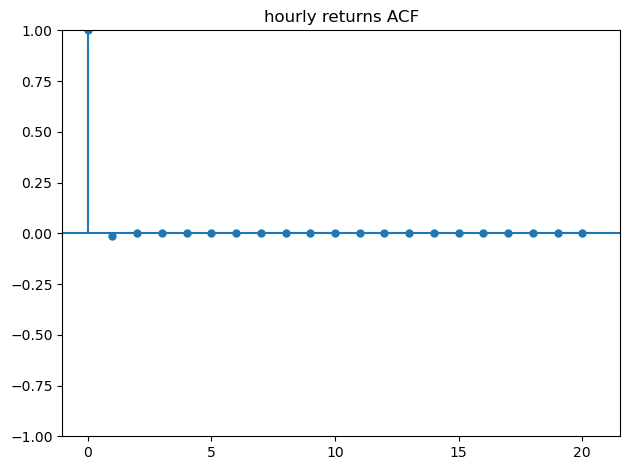

<Figure size 600x300 with 0 Axes>

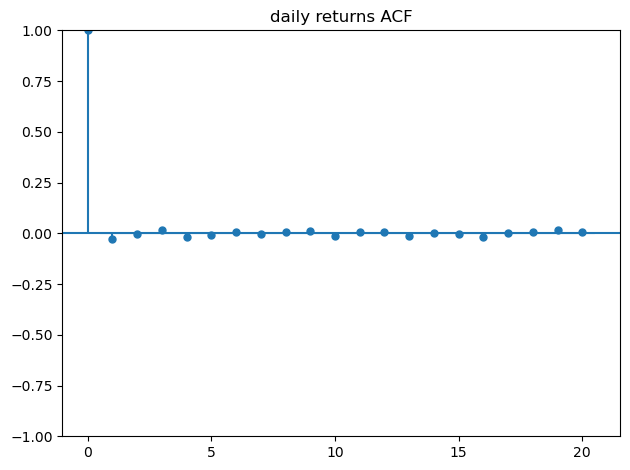

<Figure size 600x300 with 0 Axes>

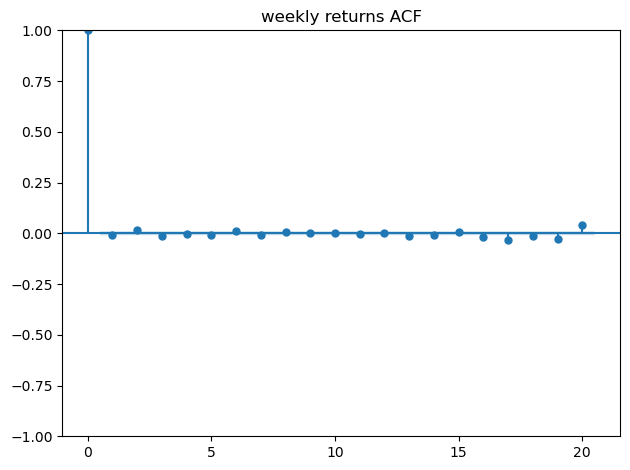

In [15]:
from pyspark.sql import functions as F
from functools import reduce


all_ret = (hourly
           .unionByName(daily)
           .unionByName(weekly)
           .filter(F.col("return_pct").isNotNull())
            .cache()
          )


all_ret.groupBy("period").count().show()


pdf = all_ret.toPandas()


print(pdf.groupby("period")["return_pct"].describe())

# autocollelation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

for per in ["hourly","daily","weekly"]:
    vals = pdf.loc[pdf.period==per, "return_pct"].dropna()
    plt.figure(figsize=(6,3))
    plot_acf(vals, lags=20, title=f"{per} returns ACF")
    plt.tight_layout()


daily = pdf[pdf.period=="daily"].copy()

th = daily.return_pct.quantile(0.9)
daily["next_return"] = daily.groupby("ticker")["return_pct"].shift(-1)
signal = daily.return_pct > th

win_rate = (daily.loc[signal, "next_return"] < 0).mean()
print(f"Daily top-10% 異動後隔日反手空的win rate：{win_rate:.1%}")

### Using only 100 for checking outliers

In [16]:
avg_vol = (
    spark_df
      .groupBy("ticker")
      .agg(F.mean("volume").alias("avg_vol"))
)


top100 = (
    avg_vol
      .orderBy(F.desc("avg_vol"))
      .limit(100)
      .select("ticker")
)

# Only use top 100 to avoid outliers
top100_list = [r.ticker for r in top100.collect()]

filtered = spark_df.filter(F.col("ticker").isin(top100_list))


hourly_top100 = make_returns(filtered, "hour",  "hourly")
daily_top100  = make_returns(filtered, "day",   "daily")
weekly_top100 = make_returns(filtered, "week",  "weekly")

from functools import reduce
from pyspark.sql import DataFrame

all_ret_top100 = (
    hourly_top100.unionByName(daily_top100)
                   .unionByName(weekly_top100)
                   .filter(F.col("return_pct").isNotNull())
)

pdf_top100 = all_ret_top100.toPandas()
print(pdf_top100.groupby("period")["return_pct"].describe())

           count      mean        std        min       25%       50%  \
period                                                                 
daily    52754.0  0.098399   2.759648 -49.384405 -0.937354  0.028331   
hourly  695850.0  0.138256  19.082129 -98.540572 -0.203663  0.000000   
weekly   10362.0  0.463068   5.320697 -31.587189 -2.210651  0.240072   

             75%          max  
period                         
daily   1.054071    97.235403  
hourly  0.221110  6792.000000  
weekly  2.740236    62.349824  


In [17]:
# find outlier
extreme_thresh = 100  # 百分比，只要超过 ±100%
outliers = pdf[ pdf.return_pct.abs() > extreme_thresh ]
print("极端值样本（ticker, period, ts, return_pct）:")
print(outliers[["ticker","period","ts","return_pct"]])

极端值样本（ticker, period, ts, return_pct）:
        ticker  period                  ts  return_pct
1477156   GOLD  hourly 2024-06-03 14:00:00      6792.0


Detected outlier tickers: ['GOLD']

After dropping outliers, return_pct describe:
             count      mean       std        min       25%       50%  \
period                                                                 
daily    218123.0  0.075080  1.944165 -39.694336 -0.827739  0.060551   
hourly  2314921.0  0.007311  0.629344 -35.540102 -0.206186  0.000000   
weekly    44245.0  0.377735  4.246057 -42.498205 -1.838755  0.297915   

             75%        max  
period                       
daily   0.961074  63.648124  
hourly  0.225479  44.060886  
weekly  2.397434  79.063361  


<Figure size 600x300 with 0 Axes>

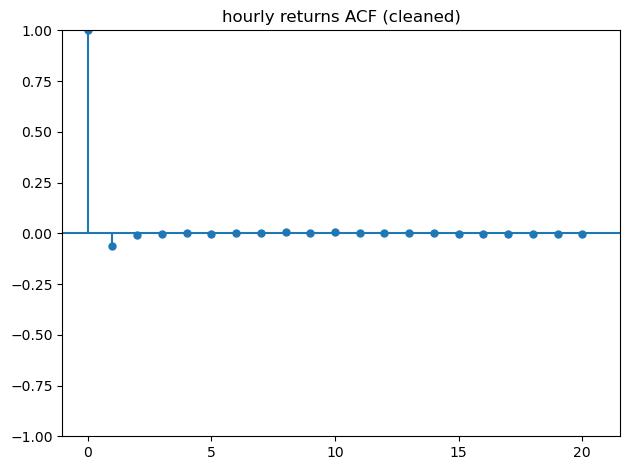

<Figure size 600x300 with 0 Axes>

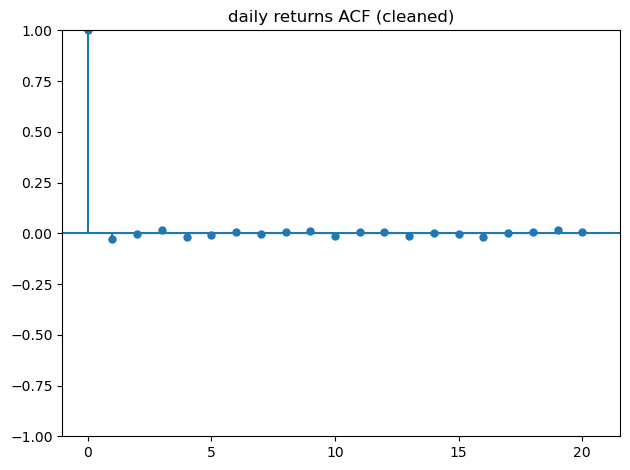

<Figure size 600x300 with 0 Axes>

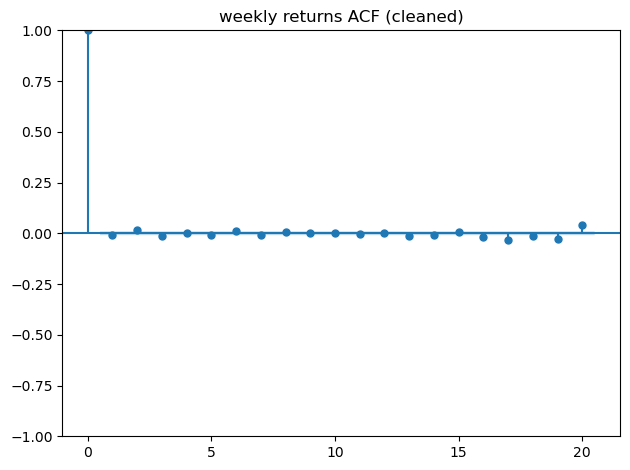

Daily top-10% cleaned win rate: 50.6%


In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


extreme_thresh = 100  # 阈值：±100%
outlier_tickers = pdf.loc[pdf.return_pct.abs() > extreme_thresh, 'ticker'].unique()
print("Detected outlier tickers:", outlier_tickers)

pdf_clean = pdf[~pdf.ticker.isin(outlier_tickers)].copy()


desc = pdf_clean.groupby('period')['return_pct'].describe()
print("\nAfter dropping outliers, return_pct describe:\n", desc)


for per in ['hourly', 'daily', 'weekly']:
    vals = pdf_clean.loc[pdf_clean.period == per, 'return_pct'].dropna()
    plt.figure(figsize=(6, 3))
    plot_acf(vals, lags=20, title=f"{per} returns ACF (cleaned)")
    plt.tight_layout()
    plt.show()


daily = pdf_clean[pdf_clean.period == "daily"].copy()
th = daily.return_pct.quantile(0.9)
daily["next_return"] = daily.groupby("ticker")["return_pct"].shift(-1)
signal = daily.return_pct > th
win_rate = (daily.loc[signal, "next_return"] < 0).mean()
print(f"Daily top-10% cleaned win rate: {win_rate:.1%}")

# LSTM model

In [19]:
df_aapl = df10[df10['ticker']=='AAPL'].sort_values('dt')

# get volume
data = df_aapl[['close','vol']].values


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# rolloing window, predict next close price
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 20
X, y = create_sequences(data_scaled, SEQ_LEN)

# train/ test  80/20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:

model = Sequential([
    LSTM(32, input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0479 - val_loss: 0.0015
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0014

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


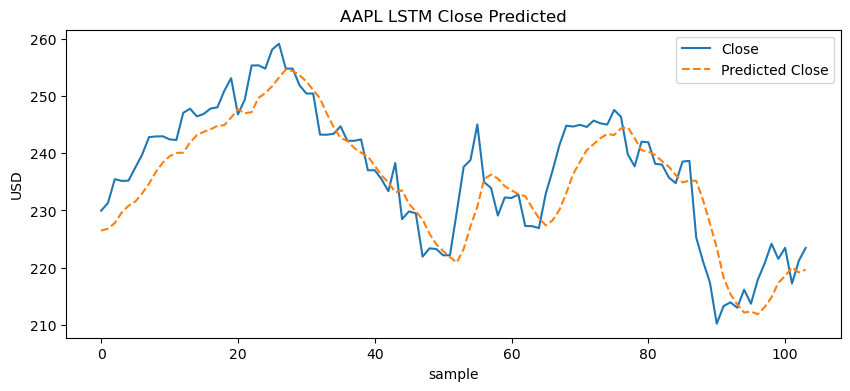

In [21]:

y_pred = model.predict(X_test)

dummy = np.zeros((len(y_pred), 2))
dummy[:,0] = y_pred.flatten()
inv_pred = scaler.inverse_transform(dummy)[:,0]

dummy[:,0] = y_test
inv_true = scaler.inverse_transform(dummy)[:,0]


plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Close')
plt.plot(inv_pred, label='Predicted Close', linestyle='--')
plt.title("AAPL LSTM Close Predicted")
plt.xlabel("sample")
plt.ylabel("USD")
plt.legend()
plt.show();